Búsqueda de hiperparámetros utilizando Optimización Bayesiana
=============================================================

## Introducción

En términos sencillos, la optimización bayesiana usa estadística bayesianas para estimar la distribución de los mejores hiperparámetros. Durante el proceso de búsqueda, el algoritmo actualiza sus creencias sobre la distribución probabilistica de los mejores hiperparámetros en función del impacto observado de cada hiperparámetro en el rendimiento del modelo. 

Esto le permite converger gradualmente en el conjunto óptimo de hiperparámetros mientras que realiza una exploración más eficiente al modificar los parameteros moviendolos en la dirección que mejora la performance.

## Entrenando y optimizando parámetros para el problema censo de la UCI

### Instalación

In [2]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/experimentation/code/tuning_bayesian.txt \
    --quiet --no-clobber
!pip install -r tuning_bayesian.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 2.5 MB/s eta 0:00:00


### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [3]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets/uci_census
!unzip -qq uci_census.zip -d datasets/uci_census

Lo importamos

In [4]:
import pandas as pd
import numpy as np

train = pd.read_csv('datasets/uci_census/data/adult-train.csv')
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')

### Creando un modelo base para luego ajustar

Preparando nuestros conjuntos de datos

In [5]:
X_train = train.drop(['income'], axis=1)
y_train = train['income'].to_numpy()
X_test = test.drop(['income'], axis=1)
y_test = test['income'].to_numpy()

In [6]:
classes = train['income'].unique().tolist()
features = X_train.columns.values.tolist()
categorical_features = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

Realizaremos un pequeño preprocesamiento antes de entrenar el modelo:

- Imputaremos los valores faltantes de las caracteristicas numéricas con la media
- Imputaremos los valores faltantes de las caracteristicas categóricas con el valor `?`
- Escalaremos los valores numericos utilizando un `StandardScaler`
- Codificaremos las variables categóricas utilizando `OneHotEncoder`

In [7]:
from typing import Tuple, List

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def prepare(X: pd.DataFrame) -> Tuple[np.ndarray, sklearn.compose.ColumnTransformer]:
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    
    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    transformations = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])
    X = transformations.fit_transform(X)
    
    return X, transformations


X_train_transformed, transformations = prepare(X_train)
X_test_transformed = transformations.transform(X_test)

Entrenamos un modelo basado en `lightgbm`

In [8]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=5)
model = clf.fit(X_train_transformed, y_train)

Ejecutamos el modelo

In [9]:
predictions = model.predict(X_test_transformed)

Podemos revisar la performance del modelo:

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       <=50K       0.81      1.00      0.90     12435
        >50K       0.98      0.25      0.40      3846

    accuracy                           0.82     16281
   macro avg       0.90      0.63      0.65     16281
weighted avg       0.85      0.82      0.78     16281



### Búsqueda de hiperparámetros con rangos predefinidos

Para comenzar, utilizaremos una optimización bayesiana para buscar la mejor combinación de parámetros de una selección predefinida de valores:

In [11]:
from skopt import BayesSearchCV

In [12]:
parameters = {
    "n_estimators": [10, 50, 100],
    "subsample":[0.6, 0.8, 1],
    "learning_rate":[0.01, 0.1, 0.5, 1],
    "gamma":[0.01, 0.1, 1, 5],
    "colsample_bytree":[0.5, 0.7, 0.9, 1],
}

In [14]:
bayes_search = BayesSearchCV(
    estimator=LGBMClassifier(random_state=1),
    search_spaces=parameters,
    n_iter=20,
    cv=5
  )

In [15]:
best_model = bayes_search.fit(X_train_transformed, y_train, verbose=2)

Ejecutamos el modelo

In [16]:
predictions = best_model.predict(X_test_transformed)

Podemos revisar la performance del modelo:

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     12435
        >50K       0.78      0.66      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.80      0.82     16281
weighted avg       0.87      0.87      0.87     16281



### Búsqueda de hiperparámetros en rangos continuos

El uso de valores discretos para representar un hiperparámetro en un espacio continuo no es óptimo. `Scikit-Optimize` nos permite definir un rango continuo con una distribución predefinida (como `log-uniform`) y especificar límites superior e inferior para cada hiperparámetro.

In [18]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score

space  = {
    'max_depth': Integer(1, 20),
    'learning_rate': Real(10**-5, 10**0, "log-uniform"),
    'subsample': Real(0.5, 1,"uniform"),
    'gamma': Real(10**-5, 10**1, "uniform"),
    'alpha': Real(10**-5, 10**0, "uniform"),
}

In [19]:
bayes_search = BayesSearchCV(
    estimator=LGBMClassifier(random_state=1),
    search_spaces=space,
    n_iter=20, 
    cv=5
  )

In [20]:
best_model = bayes_search.fit(X_train_transformed, y_train, verbose=2)

Ejecutamos el modelo

In [21]:
predictions = best_model.predict(X_test_transformed)

Podemos revisar la performance del modelo:

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     12435
        >50K       0.78      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.80      0.81     16281
weighted avg       0.87      0.87      0.87     16281



### Búsqueda de hiperparámetros con funciones de costo específicas

Cada problema de optimización tiene una función objetivo (a veces llamada función de costo o función de error). En este ejemplo, definiremos nuestra función objetivo como el error absoluto medio, por lo que la búsqueda bayesiana intentará minimizarlo. 

Una vez que tenemos una función objetivo, debemos realizar la búsqueda para encontrar el conjunto de hiperparámetros que minimizan nuestro error absoluto medio. Podemos usar `gp_minimize` de `scikit-optimize` para ejecutar esta optimización.

In [23]:
from skopt.space import Real, Integer

space = [
    Integer(1, 20, name='max_depth'),
    Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
    Real(0.5, 1,"uniform", name='subsample'),
    Real(10**-5, 10**1, "uniform", name='gamma'),
    Real(10**-5, 10**0, "uniform", name='alpha'),
]

> Note como en este caso, el espacio de búsqueda se indica como una lista de valores, en lugar de como un diccionario.

Creamos la función objetivo que necesitamos minimizar:

In [95]:
from sklearn.model_selection import cross_val_score, cross_validate
from skopt.utils import use_named_args
import time

# El decorator "use_named_args" le permite a la funcion objetivo
# los parametros como un diccionario de valores.
@use_named_args(space)
def objective(**params):
    global clf 
    
    clf = LGBMClassifier(**params)
    cv_results = cross_validate(clf, X_train_transformed, y_train, scoring="balanced_accuracy", cv=5, n_jobs=-1)
    metric = np.mean(cv_results["test_score"])

    print(f"Last know value: {metric}", end='\r', flush=True)
    time.sleep(1)
    return -metric

> Tip: Puede usar `sklearn.metrics.get_scorer_names()` para obtener un listado de todas las métricas que puede especificar en el parametro `scoring`.

Ejecutamos el proceso de optimización:

In [96]:
from skopt import gp_minimize

res_gp = gp_minimize(objective, space, n_initial_points=10, n_calls=50)

Veamos la performance gráficamente:

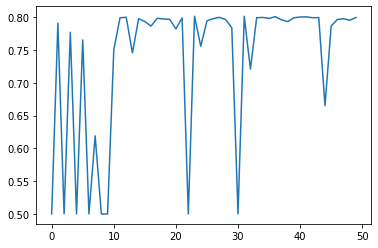

In [99]:
import matplotlib.pyplot as plt

plt.plot(-res_gp.func_vals)

Una vez finalizada la búsqueda, podemos inspeccionar los mejores hiperparámetros:

In [100]:
clf

LGBMClassifier(alpha=1e-05, gamma=10.0, learning_rate=0.18503612539810424,
               max_depth=7, subsample=0.989049662693893)